In [31]:
import pandas as pd
import numpy as np
import json
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt

In [32]:
df = pd.read_csv("working_data.csv")

# Separate descriptors and target
player_descriptors = df.iloc[:, :3]
league = df['Lg']
cy_young_place = df['Cy_young']
X = df.iloc[:, 3:-1]

# Add league temporarily for sorting
X['Lg'] = league
y = cy_young_place

# Create separate datasets
x_al = X[X['Lg'] == 'AL'].drop(columns=['Lg'])
x_nl = X[X['Lg'] == 'NL'].drop(columns=['Lg'])

y_al = y[league == 'AL']
y_nl = y[league == 'NL']


In [33]:
# Read selected features (from forest importance)
with open('forest_importance_nl.json', 'r') as f:
    selected_features_nl_importance = json.load(f)

with open('forest_importance_al.json', 'r') as f:
    selected_features_al_importance = json.load(f)

# Read selected features (from Chi-squared)
with open('chi2_selected_features_nl.json', 'r') as f:
    selected_features_nl_chi2 = json.load(f)


with open('chi2_selected_features_al.json', 'r') as f:
    selected_features_al_chi2 = json.load(f)

# Print selected features
print("Selected Features for NL:", selected_features_nl_importance)
print("Selected Features for AL:", selected_features_al_importance)
print("Selected Features for NL:", selected_features_nl_chi2)
print("Selected Features for AL:", selected_features_al_chi2)

Selected Features for NL: ['WAR', 'SO', 'ERA', 'W', 'FIP', 'IP', 'ERA+', 'WHIP', 'BF', 'W-L%']
Selected Features for AL: ['WAR', 'SO', 'FIP', 'ERA+', 'IP', 'ERA', 'BF', 'W', 'WHIP', 'GS']
Selected Features for NL: ['WAR', 'W', 'ERA', 'CG', 'SHO', 'IP', 'SO', 'BF', 'ERA+', 'FIP']
Selected Features for AL: ['WAR', 'W', 'CG', 'SHO', 'IP', 'SO', 'BK', 'BF', 'ERA+', 'FIP']


In [34]:
#Random Forest Importance
x_nl_importance = x_nl[selected_features_nl_importance]
x_al_importance = x_al[selected_features_al_importance]

# Chi-squared Features
x_nl_chi2 = x_nl[selected_features_nl_chi2]
x_al_chi2 = x_al[selected_features_al_chi2]


In [35]:
#forest feature trees
clf_nl_forest = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=11, class_weight='balanced')
clf_nl_forest.fit(x_nl_importance, y_nl)
clf_al_forest = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=11, class_weight='balanced')
clf_al_forest.fit(x_al_importance, y_al)

#chi2 feature trees
clf_nl_chi2 = DecisionTreeClassifier(criterion='entropy',max_depth=4, max_leaf_nodes=11, class_weight='balanced')
clf_nl_chi2.fit(x_nl_chi2, y_nl)
clf_al_chi2 = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=11, class_weight='balanced')
clf_al_chi2.fit(x_al_chi2, y_al)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, max_leaf_nodes=11)

Plot the Trees


forest tree nl:



[Text(0.375, 0.9166666666666666, 'x[0] <= 4.05\nentropy = 1.052\nsamples = 353\nvalue = [304.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 4.0, 2.0\n2.0, 4.0]'),
 Text(0.14285714285714285, 0.75, 'x[1] <= 171.5\nentropy = 0.357\nsamples = 302\nvalue = [290, 0, 0, 0, 1, 2, 1, 1, 2, 1, 2, 2]'),
 Text(0.2589285714285714, 0.8333333333333333, 'True  '),
 Text(0.07142857142857142, 0.5833333333333334, 'entropy = 0.036\nsamples = 262\nvalue = [261, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]'),
 Text(0.21428571428571427, 0.5833333333333334, 'x[7] <= 14.5\nentropy = 1.65\nsamples = 40\nvalue = [29, 0, 0, 0, 1, 2, 1, 1, 2, 1, 1, 2]'),
 Text(0.14285714285714285, 0.4166666666666667, 'x[3] <= 3.045\nentropy = 0.905\nsamples = 33\nvalue = [28, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2]'),
 Text(0.07142857142857142, 0.25, 'entropy = 1.585\nsamples = 3\nvalue = [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]'),
 Text(0.21428571428571427, 0.25, 'entropy = 0.561\nsamples = 30\nvalue = [27, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2]'),
 Text(0.2857142857

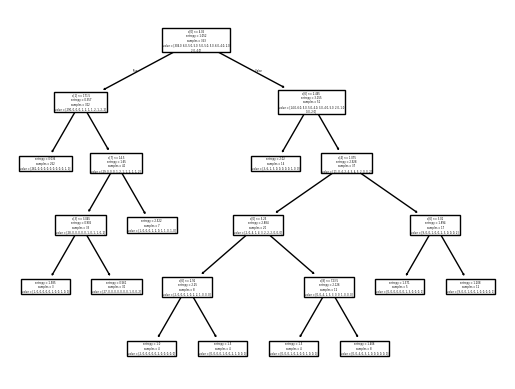

In [12]:
print("forest tree nl:\n")
plot_tree(clf_nl_forest)


forest tree al:



[Text(0.4230769230769231, 0.875, 'x[1] <= 179.5\nentropy = 0.935\nsamples = 365\nvalue = [321.0, 5.0, 5.0, 4.0, 5.0, 5.0, 6.0, 4.0, 3.0, 4.0\n2.0, 1.0]'),
 Text(0.15384615384615385, 0.625, 'x[0] <= 3.75\nentropy = 0.184\nsamples = 304\nvalue = [298, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0]'),
 Text(0.28846153846153844, 0.75, 'True  '),
 Text(0.07692307692307693, 0.375, 'entropy = 0.0\nsamples = 287\nvalue = [287, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.23076923076923078, 0.375, 'x[8] <= 1.055\nentropy = 1.731\nsamples = 17\nvalue = [11, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0]'),
 Text(0.15384615384615385, 0.125, 'entropy = 1.5\nsamples = 4\nvalue = [0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0]'),
 Text(0.3076923076923077, 0.125, 'entropy = 0.773\nsamples = 13\nvalue = [11, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]'),
 Text(0.6923076923076923, 0.625, 'x[0] <= 4.15\nentropy = 2.982\nsamples = 61\nvalue = [23, 5, 5, 3, 4, 5, 6, 3, 1, 4, 1, 1]'),
 Text(0.5576923076923077, 0.75, '  False'),
 Text(0.5384615384615384, 0.

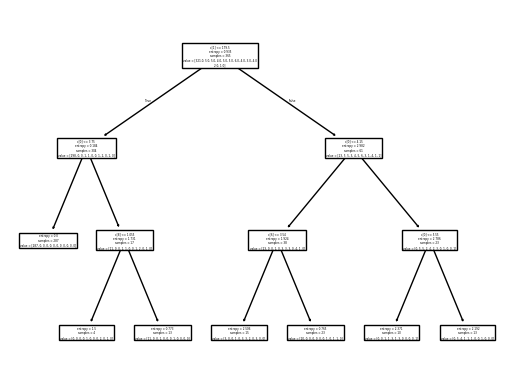

In [8]:
print("forest tree al:\n")
plot_tree(clf_al_forest)

chi2 tree nl:



[Text(0.5, 0.875, 'x[0] <= 4.05\nentropy = 1.052\nsamples = 353\nvalue = [304.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 4.0, 2.0\n2.0, 4.0]'),
 Text(0.25, 0.625, 'x[6] <= 171.5\nentropy = 0.357\nsamples = 302\nvalue = [290, 0, 0, 0, 1, 2, 1, 1, 2, 1, 2, 2]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[3] <= 1.5\nentropy = 0.036\nsamples = 262\nvalue = [261, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]'),
 Text(0.0625, 0.125, 'entropy = 0.0\nsamples = 256\nvalue = [256, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.1875, 0.125, 'entropy = 0.65\nsamples = 6\nvalue = [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]'),
 Text(0.375, 0.375, 'x[1] <= 14.5\nentropy = 1.65\nsamples = 40\nvalue = [29, 0, 0, 0, 1, 2, 1, 1, 2, 1, 1, 2]'),
 Text(0.3125, 0.125, 'entropy = 0.905\nsamples = 33\nvalue = [28, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2]'),
 Text(0.4375, 0.125, 'entropy = 2.522\nsamples = 7\nvalue = [1, 0, 0, 0, 1, 2, 0, 1, 1, 0, 1, 0]'),
 Text(0.75, 0.625, 'x[2] <= 2.465\nentropy = 3.155\nsamples = 51\nvalue = [14.0, 

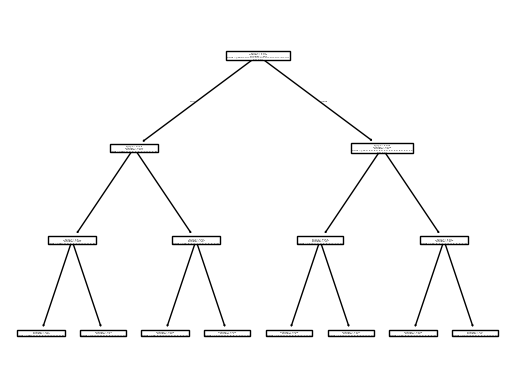

In [9]:
print("chi2 tree nl:\n")
plot_tree(clf_nl_chi2)

chi2 tree al:



[Text(0.4230769230769231, 0.875, 'x[5] <= 179.5\nentropy = 0.935\nsamples = 365\nvalue = [321.0, 5.0, 5.0, 4.0, 5.0, 5.0, 6.0, 4.0, 3.0, 4.0\n2.0, 1.0]'),
 Text(0.15384615384615385, 0.625, 'x[0] <= 3.75\nentropy = 0.184\nsamples = 304\nvalue = [298, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0]'),
 Text(0.28846153846153844, 0.75, 'True  '),
 Text(0.07692307692307693, 0.375, 'entropy = 0.0\nsamples = 287\nvalue = [287, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.23076923076923078, 0.375, 'x[4] <= 156.0\nentropy = 1.731\nsamples = 17\nvalue = [11, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0]'),
 Text(0.15384615384615385, 0.125, 'entropy = 0.0\nsamples = 8\nvalue = [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.3076923076923077, 0.125, 'entropy = 2.419\nsamples = 9\nvalue = [3, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0]'),
 Text(0.6923076923076923, 0.625, 'x[0] <= 4.15\nentropy = 2.982\nsamples = 61\nvalue = [23, 5, 5, 3, 4, 5, 6, 3, 1, 4, 1, 1]'),
 Text(0.5576923076923077, 0.75, '  False'),
 Text(0.5384615384615384, 0.37

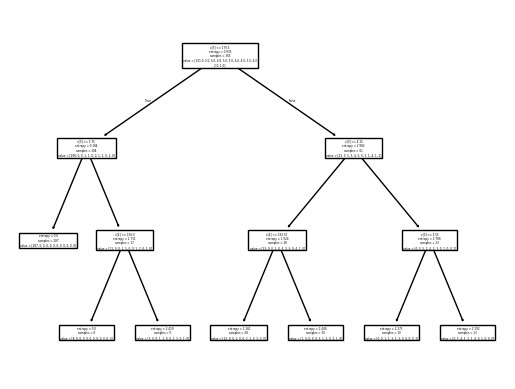

In [10]:
print("chi2 tree al:\n")
plot_tree(clf_al_chi2)

In [36]:
#Model Evaluation 
k = 15
#Importance Trees
kf_nl_importance = KFold(n_splits=k, shuffle=True, random_state=42)
scores_nl_importance = cross_val_score(clf_nl_forest, x_nl_importance, y_nl, cv=kf_nl_importance)
print(f"Accuracy for each fold: {scores_nl_importance}")
print(f"Average accuracy NL Importance: {np.mean(scores_nl_importance):.4f}")

kf_al_importance = KFold(n_splits=k, shuffle=True, random_state=42)
scores_al_importance = cross_val_score(clf_al_forest, x_al_importance, y_al, cv=kf_al_importance)
print(f"Accuracy for each fold: {scores_al_importance}")
print(f"Average accuracy AL importance: {np.mean(scores_al_importance):.4f}")


#Chi2 Trees 
kf_nl_chi2 = KFold(n_splits=k, shuffle=True, random_state=42)
scores_nl_chi2 = cross_val_score(clf_nl_chi2, x_nl_chi2, y_nl, cv=kf_nl_chi2)
print(f"Accuracy for each fold: {scores_nl_chi2}")
print(f"Average accuracy NL chi2: {np.mean(scores_nl_chi2):.4f}")

kf_al_chi2 = KFold(n_splits=k, shuffle=True, random_state=42)
scores_al_chi2 = cross_val_score(clf_al_chi2, x_al_chi2, y_al, cv=kf_al_chi2)
print(f"Accuracy for each fold: {scores_al_chi2}")
print(f"Average accuracy AL chi2: {np.mean(scores_al_chi2):.4f}")


Accuracy for each fold: [0.625      0.58333333 0.66666667 0.83333333 0.66666667 0.83333333
 0.70833333 0.91666667 0.7826087  0.7826087  0.60869565 0.7826087
 0.56521739 0.69565217 0.82608696]
Average accuracy NL Importance: 0.7251
Accuracy for each fold: [0.64       0.64       0.72       0.52       0.72       0.875
 0.79166667 0.91666667 0.83333333 0.70833333 0.70833333 0.875
 0.75       0.75       0.91666667]
Average accuracy AL importance: 0.7577
Accuracy for each fold: [0.5        0.54166667 0.66666667 0.83333333 0.625      0.79166667
 0.5        0.83333333 0.7826087  0.52173913 0.56521739 0.65217391
 0.60869565 0.69565217 0.82608696]
Average accuracy NL chi2: 0.6629
Accuracy for each fold: [0.68       0.72       0.72       0.8        0.72       0.875
 0.79166667 0.91666667 0.83333333 0.66666667 0.70833333 0.875
 0.75       0.66666667 0.91666667]
Average accuracy AL chi2: 0.7760


In my reasearch it showed that KFold is not the best way to calculate accuracy for decision trees. So I will try with StratifiedKFold

In [37]:
from sklearn.model_selection import StratifiedKFold
k = 5
#Importance Trees
skf_nl_importance = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores_nl_importance = cross_val_score(clf_nl_forest, x_nl_importance, y_nl, cv=skf_nl_importance)
print(f"Accuracy for each fold: {scores_nl_importance}")
print(f"Average accuracy NL Importance: {np.mean(scores_nl_importance):.4f}")

skf_al_importance = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores_al_importance = cross_val_score(clf_al_forest, x_al_importance, y_al, cv=skf_al_importance)
print(f"Accuracy for each fold: {scores_al_importance}")
print(f"Average accuracy AL importance: {np.mean(scores_al_importance):.4f}")


#Chi2 Trees 
skf_nl_chi2 = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores_nl_chi2 = cross_val_score(clf_nl_chi2, x_nl_chi2, y_nl, cv=skf_nl_chi2)
print(f"Accuracy for each fold: {scores_nl_chi2}")
print(f"Average accuracy NL chi2: {np.mean(scores_nl_chi2):.4f}")

skf_al_chi2 = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores_al_chi2 = cross_val_score(clf_al_chi2, x_al_chi2, y_al, cv=skf_al_chi2)
print(f"Accuracy for each fold: {scores_al_chi2}")
print(f"Average accuracy AL chi2: {np.mean(scores_al_chi2):.4f}")

C:\Users\jbigs\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\jbigs\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\jbigs\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\jbigs\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy for each fold: [0.74647887 0.66197183 0.74647887 0.7        0.74285714]
Average accuracy NL Importance: 0.7196
Accuracy for each fold: [0.8630137  0.73972603 0.78082192 0.76712329 0.69863014]
Average accuracy AL importance: 0.7699
Accuracy for each fold: [0.74647887 0.63380282 0.70422535 0.68571429 0.72857143]
Average accuracy NL chi2: 0.6998
Accuracy for each fold: [0.8630137  0.73972603 0.78082192 0.75342466 0.79452055]
Average accuracy AL chi2: 0.7863


KFold and StratifiedKFold are great for predicting accuracy, however, in a dataset flooded with cy-young losers it will imbalance the data. I will use F1 score which weighs precision and recall to see how many times it correctly predicts the winner

In [38]:
#First we predict a class based on our model
y_nl_importance_pred = clf_nl_forest.predict(x_nl_importance)
y_al_importance_pred = clf_al_forest.predict(x_al_importance)
y_nl_chi2_pred = clf_nl_chi2.predict(x_nl_chi2)
y_al_chi2_pred = clf_al_chi2.predict(x_al_chi2)



In [39]:
#Now we can use f1 to show the relation between precision and recall
from sklearn.metrics import f1_score

f1_nl_importance = f1_score(y_nl, y_nl_importance_pred, average='macro')
print("F1 Score NL Importance:", f1_nl_importance)

f1_al_importance = f1_score(y_al, y_al_importance_pred, average='macro')
print("F1 Score AL Importance:", f1_al_importance)

f1_nl_chi2 = f1_score(y_nl, y_nl_chi2_pred, average='macro')
print("F1 Score NL Chi2:", f1_nl_chi2)

f1_al_chi2 = f1_score(y_al, y_al_chi2_pred, average='macro')
print("F1 Score AL Chi2:", f1_al_chi2)

F1 Score NL Importance: 0.36127188900024015
F1 Score AL Importance: 0.43888248082327025
F1 Score NL Chi2: 0.3885625454983633
F1 Score AL Chi2: 0.45099721793800734
